https://www.kaggle.com/c/datalab-cup3-reverse-image-caption-2020

# 深度學習 伯伯會社 第5組 Competition03 報告

## 組員:江伯耕、蔣嘉霖、周秉儒、陳炘昱


In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path
import re
from IPython import display
%matplotlib inline

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[5], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

7 Physical GPUs, 1 Logical GPUs


In [3]:
dictionary_path ='./dictionary/'



N_EPOCH_RNN = 250
alpha = 0.8  # 0.4 0.8


In [4]:
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))
word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [5]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    
    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]
    
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l
    
    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]

    return line
text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))
def idList2sent(idList, is_int=True):
    if is_int:
        return " ".join([id2word_dict[str(i)] for i in idList if id2word_dict[str(i)] != "<PAD>" and id2word_dict[str(i)] != "<RARE>"])
    else:
        return " ".join([id2word_dict[i] for i in idList if id2word_dict[i] != "<PAD>" and id2word_dict[i] != "<RARE>"])

the flower shown has yellow anther red pistil and bright red petals.
['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427']


In [6]:
data_path = './dataset'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))

There are 7370 image in training data


In [7]:
# aug_controller
left_right_flip_p = 0.5
noise_p = 0.3
rotation_p = 0.4
crop_p = 0.3
contrast_p = 0.4

# Data Augmentation

我們用了下列的作法進行 Data Augmentation

1.resize with crop or pad

2.random crop

3.add noise

4.random flip up down

5.random flip left right

In [8]:
@tf.function
def random_flip(image):
    right_left_outcome = tf.random.uniform([1], 0, 1)
    if right_left_outcome<left_right_flip_p:
        image = tf.image.flip_left_right(image)
    return image

@tf.function
def random_rotation(image):
    prob = tf.random.uniform([1],0,1)
    if prob < (rotation_p/2):
        image = tf.image.rot90(image, k = 1 )
    elif (prob >= (rotation_p/2)) and (prob < rotation_p):
        image = tf.image.rot90(image, k = 3 )   
    return image

@tf.function
def random_crop(image):
    prob = tf.random.uniform([1],0,1)
    if prob < crop_p:
        image = tf.image.resize(image, size=[IMAGE_HEIGHT + 5, IMAGE_WIDTH + 5])
        image = tf.image.random_crop(image, size=[IMAGE_HEIGHT, IMAGE_WIDTH, 3])
    else:
        image = tf.image.resize(image, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
        
    return image
@tf.function
def adj_contrast(image):
    prob = tf.random.uniform([1], 0, 1)
    if prob < contrast_p:
        image = tf.image.random_contrast(image, 0.9, 2)
    return image

In [9]:
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

def training_data_generator(caption, image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    short_side = tf.minimum(tf.shape(img)[0], tf.shape(img)[1])
    img = tf.image.resize_with_crop_or_pad(img, short_side, short_side)
    img = tf.image.resize(img, size=[64 * 76 // 64, 64 * 76 // 64])
    img = tf.image.random_crop(img, [64,64,3])
    img = img*2-1.
    noise = tf.random.normal(img.shape,stddev=0.02)
    img = tf.math.add(img,noise)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_flip_left_right(img)
    caption = tf.cast(caption, tf.int32)
    return img, caption

def training_data_generator_only_image(caption, image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    short_side = tf.minimum(tf.shape(img)[0], tf.shape(img)[1])
    img = tf.image.resize_with_crop_or_pad(img, short_side, short_side)
    img = tf.image.resize(img, size=[64 * 76 // 64, 64 * 76 // 64])
    img = tf.image.random_crop(img, [64,64,3])
    img = img*2-1.
    noise = tf.random.normal(img.shape,stddev=0.02)
    img = tf.math.add(img,noise)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_flip_left_right(img)
    
    return img

def training_data_generator_only_caption(caption, image_path):
    caption = tf.cast(caption, tf.int32)
    return caption

def training_data_generator_rnn(caption, image_path):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=[128, 128])
    img.set_shape([128, 128, IMAGE_CHANNEL])
    
    img = tf.image.resize_with_crop_or_pad(img,128 + 10, 128 + 10)
    img = tf.image.random_crop(img, [128,128, IMAGE_CHANNEL])    
    noise = tf.random.normal(img.shape,stddev=0.01)
    img = tf.math.add(img,noise)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    caption = tf.cast(caption, tf.int32)
    return img, caption


In [10]:
class dataset_generator():
    
    def __init__(self, filenames, batch_size):
        self.batch_size = batch_size
        df = pd.read_pickle(filenames)
        captions = df['Captions'].values
        self.caption = []
        for i in range(len(captions)):
            self.caption.append(random.choice(captions[i]))
        self.caption = np.asarray(self.caption)
        self.caption = self.caption.astype(np.int)
        self.image_path = df['ImagePath'].values
        assert self.caption.shape[0] == self.image_path.shape[0]
        
    def generate(self, generate_func):
        dataset = tf.data.Dataset.from_tensor_slices((self.caption,self.image_path))
        dataset = dataset.map(generate_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.shuffle(len(self.caption)).batch(self.batch_size, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        
        return dataset


In [11]:
par = {
    'MAX_SEQ_LENGTH': 20,                     # maximum sequence length
    'EMBED_DIM': 256,                         # word embedding dimension
    'VOCAB_SIZE': len(word2Id_dict),          # size of dictionary of captions
    'TEXT_EMBEDDING_REDUCTION':128,
    "T_DIM": 64,
    'Z_DIM': 100,                             # random noise z dimension
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': 64,
    'BATCH_SIZE_RNN': 64,
    'LR': 2e-4,
    'RNN-CNN-LR':2e-4,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 2000,
    'N_EPOCH_RNN': 250, # 50
    'N_SAMPLE': num_training_sample,          # size of training data
    'PRINT_FREQ': 1                        # printing frequency of loss                        
}

In [12]:
ds_generator = dataset_generator(data_path + '/text2ImgData.pkl', par['BATCH_SIZE_RNN'])
dataset = ds_generator.generate(training_data_generator)
dataset_wrong_image = ds_generator.generate(training_data_generator_only_image)
dataset_wrong_caption = ds_generator.generate(training_data_generator_only_caption)
dataset_rnn = ds_generator.generate(training_data_generator_rnn)

# TextEncoder
 這邊我們嘗試用２種做法訓練TextEncoder，一種是參考Conditional GAN Model的方法，另一種是參考attention gan的paper的方法，而最終我們使用Conditional GAN Model的方法產出我們的結果。

## 參考Conditional GAN Model的作法
    我們分別訓練Text Encoder及CNN Encoder，Text Encoder是用LSTM，CNN是用自行設計的CNN及 ResNet152(但ResNet152效果不好，所以我們最終採用自行設計的CNN)，並藉由Cosine similarity讓Text Encoder及CNN Encoder產生的向量盡量相似，希望可以讓Text Encoder與圖片的特徵相互對應。


In [13]:
class TextEncoder(tf.keras.Model):
    def __init__(self, par):
        super(TextEncoder, self).__init__()
        
        self.par = par
        self.batch_size = self.par['BATCH_SIZE_RNN']
        self.hidden_size = int(self.par['EMBED_DIM'])

        self.embedding = layers.Embedding(self.par['VOCAB_SIZE'], self.par['EMBED_DIM'],
                                        embeddings_initializer=tf.random_normal_initializer(stddev=0.02))
        
        self.lstm = layers.LSTM(self.hidden_size,
                                return_sequences=True,
                                return_state=True,
                                recurrent_initializer='orthogonal')
        
    
    def call(self, text, hidden):
        text = self.embedding(text)
        output= self.lstm(text, initial_state = hidden)
        return output[0][:,-1,:]
    def initialize_hidden_state(self):
        #return [tf.zeros((self.par['BATCH_SIZE_RNN'], self.hidden_size)) for i in range(2)]
        return [tf.zeros((self.par['BATCH_SIZE_RNN'], self.hidden_size)) for i in range(2)]


### 自行設計的CNN

In [14]:
class cnn_encoder(tf.keras.Model):
    def __init__(self, par):
        super(cnn_encoder, self).__init__()
        self.par = par
        self.df_dim = 64
        #h0
        self.c01 = tf.keras.layers.Conv2D(
            filters = self.df_dim,
            kernel_size = 4,
            strides = (2, 2),
            padding = "SAME",
            input_shape = (128,128,3)
        )
        self.r01 = tf.keras.layers.LeakyReLU(0.2)
        #h1
        self.c11 = tf.keras.layers.Conv2D(
            filters = self.df_dim*2,
            kernel_size = 4,
            strides = (2, 2),
            padding = "SAME"        
        )
        self.b11 = tf.keras.layers.BatchNormalization()
        self.r11 = tf.keras.layers.LeakyReLU(0.2)
            
        #h2
        self.c21 = tf.keras.layers.Conv2D(
            filters = self.df_dim*4,
            kernel_size = 4,
            strides = (2, 2),
            padding = "SAME"        
        )
        self.b21 = tf.keras.layers.BatchNormalization()
        self.r21 = tf.keras.layers.LeakyReLU(0.2)
        #h3
        self.c31 = tf.keras.layers.Conv2D(
            filters = self.df_dim*8,
            kernel_size = 4,
            strides = (2, 2),
            padding = "SAME"        
        )
        self.b31 = tf.keras.layers.BatchNormalization()
        self.r31 = tf.keras.layers.LeakyReLU(0.2)
        
        #h4
        self.c41 = tf.keras.layers.Conv2D(
            filters = self.df_dim*8,
            kernel_size = 4,
            strides = (2, 2),
            padding = "SAME"        
        )
        self.b41 = tf.keras.layers.BatchNormalization()
        self.r41 = tf.keras.layers.LeakyReLU(0.2)
        
        #final
        self.flatten = tf.keras.layers.Flatten()
        self.d = tf.keras.layers.Dense(256)
    def call(self, inputs):
        h0 = self.c01(inputs)
        h0 = self.r01(h0)
        
        #h1
        h1 = self.c11(h0)
        h1 = self.b11(h1)
        h1 = self.r11(h1)
        
        #h2
        h2 = self.c21(h1)
        h2 = self.b21(h2)
        h2 = self.r21(h2)
        #h3
        h3 = self.c31(h2)
        h3 = self.b31(h3)
        h3 = self.r31(h3)       

        final = self.flatten(h3)
        final = self.d(final)
        return final

### ResNet152
我們嘗試用pre-trained ResNet152 當CNN的架構，但效果不好。

In [ ]:
import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
#ResNet50model = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
#               input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

ResNet152model = tf.keras.applications.ResNet152(
    include_top=False, weights='imagenet',  input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3))

for layer in ResNet152model.layers:
    if layer.name in ['conv5_block3_3_conv','conv5_block3_3_bn','conv5_block3_add','conv5_block3_out']:
        layer.trainable = True
    else:
        layer.trainable = False

img_inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = ResNet152model(img_inputs)
x = layers.Flatten()(x)
outputs = layers.Dense(128, 
                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

resnet152 = keras.Model(inputs=img_inputs, outputs=outputs, name="resnet152")


### Cosine_similarity

In [15]:
def cosine_similarity(v1, v2):
    cost = tf.reduce_sum(tf.multiply(v1, v2), 1) / (tf.sqrt(tf.reduce_sum(tf.multiply(v1, v1), 1)) * tf.sqrt(tf.reduce_sum(tf.multiply(v2, v2), 1)))
    return cost
def rnn_loss(real_cnn, text_embed, wrong_cnn, wrong_text_embed):
    rnn_loss = rnn_loss = tf.reduce_mean(tf.maximum(0., alpha - cosine_similarity(real_cnn, text_embed) + cosine_similarity(real_cnn, wrong_text_embed))) + \
                tf.reduce_mean(tf.maximum(0., alpha - cosine_similarity(real_cnn, text_embed) + cosine_similarity(wrong_cnn, text_embed)))
    return rnn_loss

In [16]:
text_encoder = TextEncoder(par)
cnn_encoder = cnn_encoder(par)
rnn_optimizer = tf.keras.optimizers.Adam(par['RNN-CNN-LR'], clipnorm=10)

In [ ]:
main_path = './tune_ckpt/alpha_'+str(int(10*alpha))
os.makedirs(main_path+'/word-cnn-rnn/', exist_ok =True)
checkpoint_path = main_path+'/word-cnn-rnn/'# './tune_ckpt/word-cnn-rnn/'

In [ ]:
ckpt = tf.train.Checkpoint(rnn_optimizer=rnn_optimizer,
                        text_encoder=text_encoder)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

print(f'Resume training from epoch {start_epoch}')

In [ ]:
@tf.function
def train_step_rnn(real_image, real_caption, hidden, wrong_image, wrong_caption, wrong_hidden):
    with tf.GradientTape() as rnn_tape:
        x = cnn_encoder(real_image)
        v = text_encoder(real_caption, hidden)
        x_w = cnn_encoder(wrong_image)
        v_w = text_encoder(wrong_caption, wrong_hidden)
        r_loss = rnn_loss(x, v, x_w, v_w)
        
    grad_r = rnn_tape.gradient(r_loss, text_encoder.trainable_variables + cnn_encoder.trainable_variables)
    rnn_optimizer.apply_gradients(zip(grad_r, text_encoder.trainable_variables + cnn_encoder.trainable_variables))
    return r_loss

In [ ]:
steps_per_epoch = int(par['N_SAMPLE']/par['BATCH_SIZE_RNN'])
hidden = text_encoder.initialize_hidden_state()
mis_hidden = text_encoder.initialize_hidden_state()

In [ ]:
for epoch in range(start_epoch,par['N_EPOCH_RNN']):
    r_total_loss = 0
    start = time.time()
    ################################################################
    ds_generator = dataset_generator(data_path + '/text2ImgData.pkl', par['BATCH_SIZE_RNN'])
    # dataset = ds_generator.generate(training_data_generator)
    # dataset_wrong_image = ds_generator.generate(training_data_generator_only_image)
    # dataset_wrong_caption = ds_generator.generate(training_data_generator_only_caption)
    dataset_rnn = ds_generator.generate(training_data_generator_rnn)
    ############################################################
    for image, caption in dataset_rnn:
        mismatch_cap = caption
        break
    for image, caption in dataset_rnn:
        mismatch_img = image
        break
    for image, caption in dataset_rnn:
        r_loss = train_step_rnn(image, caption, hidden,mismatch_img,mismatch_cap,mis_hidden)
        r_total_loss += r_loss
        k = np.random.uniform()
        if k>=0.5:
            mismatch_cap = caption
        if k<0.5:
            mismatch_img = image
    time_tuple = time.localtime()
    time_string = time.strftime("%m/%d/%Y, %H:%M:%S", time_tuple)


    print("Epoch {}, rnn_loss: {:.4f}".format(epoch+1,
                                                r_total_loss/steps_per_epoch))
    print('Time for epoch {} is {:.4f} sec'.format(epoch+1, time.time()-start))
    
    # save the model
    if epoch  == 50-1 or epoch  == 150-1 or epoch  == 250-1  : # if epoch % 10 == 9:
        ckpt_manager.save(checkpoint_number=(epoch + 1))

## 參考Attention gan paper的作法

### Caption Embedding
    嘗試許多方法後，發現使用 attention gan 中訓練 caption embedding 的方法效果最好，在該篇論文中，訓練的過程會使用較大的圖片，且 CNN 的部分會使用 pre-trained InceptionV3，然後分別取出兩種 output 當作訓練 local feature 與 global feature 的目標，但是因為我們後面的 GAN 架構並不是使用 attention GAN 所以只會對 global feature 進行訓練，只會回傳一個 caption embedding 。

### DAMSM
    模型在 caption 用的是 bidirectional LSTM　並回傳最後的　hidden state，在圖片部分是使用 CNN 並且把最後的 convolution 結果做 flatten 與 linear 使其與 text encoder 的維度相同，loss 部分會計算成對與不成對圖片的 cosine similarity ，成對的希望 correlation 越大越好，而不成對的圖片希望 correlation = 0。
    
    在 attention GAN 中的 DAMSM 會回傳 bidirectional LSTM 的每一個 hidden state ，除最後一個外其他都代表著圖片某個地方的 local feature ，以方便 attention GAN 在訓練的過程中對圖片細節做修正，但是因為我們使用的 GAN 不是 attention GAN ，所以只會保留 bidirectional LSTM 的最後一層，當作 整段 caption 的 embedding。
    
    在 TextEncoder 的部分我們在 loss 方面曾經做過許多調整，因為一張圖片會有十種 caption ，所以在訓練的過程對每一張圖片與 caption 的組合都有訓練到的效果會是比較好的，在原本論文中，對不成對的圖片進行訓練是以 batch 為單位來進行計算的，但是論文推薦的 batch size 是 50 ，如果使用 pre-trained CNN model 沒有辦法使用那麼大的 batch ，為了避免訓練結果出現 bias ，我們也嘗試了直接固定圖片或是caption 對另外一個進行抽樣，且這樣寫法比較容易。
    
    CNN_Encoder 的部分，論文中是採用 inceptionV3，我們在此處有試過使用 VGG16 但是訓練時間會變得非常久，所以也有試過使用沒有 train 過的 CNN model 讓兩部分同時進行訓練，結果是還可以接受的。
    
    在這部分讓每一個 epoch 的 圖片與 caption 的對應進行重新抽樣訓練的效果會比較好。

In [ ]:
class TextEncoder(tf.keras.Model):
    def __init__(self, par):
        super(TextEncoder, self).__init__()
        
        self.par = par
        self.batch_size = self.par['BATCH_SIZE_RNN']
        self.hidden_size = int(self.par['EMBED_DIM'])

        self.embedding = layers.Embedding(self.par['VOCAB_SIZE'], self.par['EMBED_DIM'],
                                        embeddings_initializer=tf.random_normal_initializer(stddev=0.02))
        
        self.lstm = layers.LSTM(self.hidden_size,
                                return_sequences=True,
                                return_state=True,
                                recurrent_initializer='orthogonal')
        self.bid = layers.Bidirectional(self.lstm)
        # self.w1 = tf.Variable(initial_value = tf.random.normal([256,512]),trainable=True)
        # self.w2 = tf.Variable(initial_value = tf.random.normal([4,256]),trainable=True)
        # self.f = tf.keras.Sequential([
        #     tf.keras.layers.Flatten(),
        #     tf.keras.layers.Dense(256)
        # ])
    def call(self, text, hidden):
        text = self.embedding(text)
        text = tf.nn.dropout(text,0.5)
        output= self.bid(text, initial_state = hidden)
        # H = output[0]
        # Ht = tf.transpose(H,[0,2,1])
        # A = tf.nn.tanh(tf.map_fn(lambda x: tf.matmul(self.w1,x),Ht))
        # A = tf.nn.softmax(tf.map_fn(lambda x :tf.matmul(self.w2,x),A),axis = 2)
        # M = tf.matmul(A,H)
        # M = self.f(M)
        # P = tf.reduce_sum(tf.pow(tf.matmul(A,A,transpose_b=True)-tf.eye(4,4),2))
        #return M,P
        return output[0][:,-1,:],output[0][:,:19,:]
    def initialize_hidden_state(self):
        return [tf.zeros((self.par['BATCH_SIZE_RNN'], self.hidden_size)) for i in range(4)]

In [ ]:
class cnn_encoder(tf.keras.Model):
    def __init__(self, par):
        super(cnn_encoder, self).__init__()
        self.par = par
        self.embed_dim = int(self.par['EMBED_DIM']*2)
        self.vgg = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, pooling='avg')
        self.vgg.trainable = False
        self.local_feature = tf.keras.Model(inputs = self.vgg.input,outputs = self.vgg.get_layer('block4_pool').output)
        self.local_feature.trainable = False
        self.fc = tf.keras.Sequential(
         [   tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(self.embed_dim,
                                            kernel_initializer=weight_initializer,
                                            kernel_regularizer=weight_regularizer_fully
                                            )]
        )
    def call(self, x):
        code = self.vgg(x)
        code = self.fc(code)
        feature = self.local_feature(x)
        feature = tf.reshape(feature,[feature.shape[0],feature.shape[1]*feature.shape[2],feature.shape[3]])
        return code,feature

In [ ]:
text_encoder = TextEncoder(par)
cnn_encoder = cnn_encoder(par)
# cnn_encoder = resnet152
rnn_optimizer = tf.keras.optimizers.Adam(par['RNN-CNN-LR'], clipnorm=10)

In [ ]:
checkpoint_path = './ckpt/word-cnn-rnn/'

ckpt = tf.train.Checkpoint(
                        rnn_optimizer = rnn_optimizer,
                        cnn_encoder = cnn_encoder,
                        text_encoder= text_encoder)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])*10
    ckpt.restore(ckpt_manager.latest_checkpoint)

print(f'Resume training from epoch {start_epoch}')

In [ ]:
def rnn_loss(v,c):
    denom_pic = tf.norm(v,axis=1,keepdims=True)
    denom_text = tf.norm(c,axis=1,keepdims=True)
    R = 10*tf.matmul(c,v,transpose_b=True)/tf.matmul(denom_pic,denom_text,transpose_b=True)
    part1 = -1*tf.reduce_sum(tf.math.log(tf.linalg.diag_part(tf.nn.softmax(R,axis=0))))
    part2 = -1*tf.reduce_sum(tf.math.log(tf.linalg.diag_part(tf.nn.softmax(R,axis=1))))
    return part1+part2

In [ ]:
def word_loss(word,feature):
    S_bar = tf.nn.softmax(tf.matmul(word,feature,transpose_b=True),axis=1)
    alpha = tf.nn.softmax(5*S_bar,axis=2)
    C = tf.matmul(alpha,feature)
    norm_word = tf.norm(word,axis=2,keepdims=True)
    norm_C = tf.norm(C,axis=2,keepdims=True)
    R_Q_D = tf.matmul(word,C,transpose_b = True)/tf.matmul(norm_word,norm_C,transpose_b=True)
    R_Q_D = tf.math.exp(5*tf.linalg.diag_part(R_Q_D))
    R_Q_D = tf.math.log(tf.math.pow(tf.reduce_sum(R_Q_D[:,1:],axis=1),1/5))
    P_D_Q = tf.nn.softmax(10*R_Q_D)
    loss=-tf.math.log(P_D_Q)
    return loss

In [ ]:
@tf.function
def train_step_rnn(real_image, real_caption, hidden):
    with tf.GradientTape() as rnn_tape:
        v,feature = cnn_encoder(real_image)
        c,word = text_encoder(real_caption, hidden)
        part1 = tf.reduce_sum(tf.linalg.diag_part(tf.map_fn(lambda x : word_loss(tf.expand_dims(x,0),feature),word)))
        part2 = tf.reduce_sum(tf.linalg.diag_part(tf.map_fn(lambda x : word_loss(word,tf.expand_dims(x,0)),feature)))
        loss = rnn_loss(v, c)+part1+part2
    grad_r = rnn_tape.gradient(loss, text_encoder.trainable_variables + cnn_encoder.trainable_variables)
    rnn_optimizer.apply_gradients(zip(grad_r, text_encoder.trainable_variables + cnn_encoder.trainable_variables))
    return loss

In [ ]:
steps_per_epoch = int(par['N_SAMPLE']/par['BATCH_SIZE_RNN'])
hidden = text_encoder.initialize_hidden_state()
mis_hidden = text_encoder.initialize_hidden_state()

for epoch in range(start_epoch,par['N_EPOCH_RNN']):
    r_total_loss = 0    
    start = time.time()
    
    for image, caption in dataset_rnn:
        r_loss = train_step_rnn(image, caption, hidden)
        r_total_loss += r_loss
    time_tuple = time.localtime()
    time_string = time.strftime("%m/%d/%Y, %H:%M:%S", time_tuple)


    print("Epoch {}, rnn_loss: {:.4f}".format(epoch+1,
                                                r_total_loss/steps_per_epoch))
    print('Time for epoch {} is {:.4f} sec'.format(epoch+1, time.time()-start))
    
    # save the model
    if epoch % 5 == 0:
        ckpt_manager.save()

#  GAN
    https://arxiv.org/pdf/2008.05865.pdf
    
    我們使用的 GAN 是 deep fusion GAN ，在該篇論文中訓練圖片的目標是 256X256，並且使用的模型只有一個與其他訓練大張圖片的模型很多都是兩階段的架構不同。
    
    該篇論文主要提出了四個觀點，認為採用這些方法會讓訓練的結果比較好。
        
        1. 使用單一模型，不使用兩階段的過程
        
        2. Discriminator 只會進行圖片與文字是否成對的判定，不會針對圖片是否像是真的圖片進行判斷，又針對圖片是否成對進行判斷
        
        3. 將 batch normalization 改為對每一個 channel 做 affine，而使用的線性轉換與平移所使用的參數是使用 caption embedding 經過 linear 後訓練而來
        
        4. 使用 hinge loss 並對 discriminator 在真假圖片變換時的 gradient 進行 penalty，希望在真假圖片變換時 gradient 變化較為 smooth
        
        因為不像論文中需要那麼大的圖片，所以在 generator 與 discriminator 中分別只使用了5個與4個 residual block

In [23]:
class affine(tf.keras.Model):
    def __init__(self, num_features):
        super(affine, self).__init__()
        self.fc_gamma = tf.keras.Sequential([
            tf.keras.layers.Dense(256),
            tf.keras.layers.ReLU(),          
            tf.keras.layers.Dense(num_features)
            ])
        self.fc_beta = tf.keras.Sequential([
            tf.keras.layers.Dense(256),
            tf.keras.layers.ReLU(),          
            tf.keras.layers.Dense(num_features)
            ])
    def call(self,picture,text):
        weight = self.fc_gamma(text)
        bias = self.fc_beta(text)        
        weight = tf.expand_dims(tf.expand_dims(weight,1),1)
        weight = tf.tile(weight,[1,picture.shape[1],picture.shape[2],1])
        bias = tf.expand_dims(tf.expand_dims(bias,1),1)
        bias = tf.tile(bias,[1,picture.shape[1],picture.shape[2],1])
        return weight * picture + bias


In [24]:
class G_Block(tf.keras.Model):

    def __init__(self, in_ch, out_ch):
        super(G_Block, self).__init__()

        self.learnable_sc = in_ch != out_ch 
        self.c1 = tf.keras.layers.Conv2D(out_ch,3,1,padding = 'SAME')
        self.c2 = tf.keras.layers.Conv2D(out_ch,3,1,padding = 'SAME')

        self.affine0 = affine(in_ch)
        self.affine1 = affine(in_ch)
        self.affine2 = affine(out_ch)
        self.affine3 = affine(out_ch)
        
        self.gamma = tf.Variable(tf.zeros(1),trainable=True)
        if self.learnable_sc:
            self.c_sc = tf.keras.layers.Conv2D(out_ch, 1, 1, padding = 'valid')
    def shortcut(self, picture):
        if self.learnable_sc:
            picture = self.c_sc(picture)
        return picture
    def residual(self, picture, text):
        h = self.affine0(picture, text)
        h = tf.nn.leaky_relu(h)
        h = self.affine1(h, text)
        h = tf.nn.leaky_relu(h)
        h = self.c1(h)
        h = self.affine2(h, text)
        h = tf.nn.leaky_relu(h)
        h = self.affine3(h, text)
        h = tf.nn.leaky_relu(h)
        return self.c2(h)
    
    def call(self, picture, text):
        return self.shortcut(picture) + self.gamma * self.residual(picture, text)

In [25]:
class NetG(tf.keras.Model):
    def __init__(self,par):
        super(NetG, self).__init__()
        ngf = par['T_DIM']
        ngf = par['Z_DIM']
        self.ngf = ngf
        self.nz = 100
        # layer1 input 100x1x1 random noise , output size (ngf*8)x4x4
        self.fc = tf.keras.layers.Dense(ngf*8*4*4)
        self.block0 = G_Block(ngf * 8, ngf * 8)#4x4
        self.block1 = G_Block(ngf * 8, ngf * 8)#4x4
        self.block2 = G_Block(ngf * 8, ngf * 4)#8x8
        self.block3 = G_Block(ngf * 4, ngf * 2)#16x16
        self.block4 = G_Block(ngf * 2, ngf * 1)#32x32
        #self.block5 = G_Block(ngf * 2, ngf * 1)#64x64

        self.conv_img = tf.keras.Sequential(
            [tf.keras.layers.LeakyReLU(0.2),
            tf.keras.layers.Conv2D(3, 3, 1, padding = 'SAME',activation='tanh')]
        )
    def call(self, text,noise):
        out = self.fc(noise)
        out = tf.reshape(out,[64,4,4,8*self.ngf])
        out = self.block0(out,text) 
        #4*4
        out = tf.image.resize(out,[out.shape[1]*2,out.shape[2]*2])
        out = self.block1(out,text)
        #8*8
        out = tf.image.resize(out,[out.shape[1]*2,out.shape[2]*2])
        out = self.block2(out,text)
        #16*16
        out = tf.image.resize(out,[out.shape[1]*2,out.shape[2]*2])
        out = self.block3(out,text)
        #32*32
        out = tf.image.resize(out,[out.shape[1]*2,out.shape[2]*2])
        out = self.block4(out,text)
        #64*64
        out = self.conv_img(out)
        return out

In [26]:
class resD(tf.keras.Model):
    def __init__(self, fin, fout, downsample=True):
        super().__init__()
        self.downsample = downsample
        self.learned_shortcut = (fin != fout)
        self.conv_r = tf.keras.Sequential(
            [tf.keras.layers.Conv2D(fout, 4, 2, padding = "SAME", use_bias=False),
            tf.keras.layers.LeakyReLU(0.2),

            tf.keras.layers.Conv2D(fout, 3, 1, padding = 'SAME', use_bias=False),
            tf.keras.layers.LeakyReLU(0.2),]
        )

        self.conv_s = tf.keras.layers.Conv2D(fout, 1, 1, padding = 'valid')
        self.gamma = tf.Variable(tf.zeros(1))
    def shortcut(self, x):
        if self.learned_shortcut:
            x = self.conv_s(x)
        if self.downsample:
            return tf.nn.avg_pool2d(x, 2,2,padding = 'VALID')
        return x
    def residual(self, x):
        return self.conv_r(x)
    def call(self, x, c=None):
        return self.shortcut(x)+self.gamma*self.residual(x)

In [27]:
class NetD(tf.keras.Model):
    def __init__(self, ndf):
        super(NetD, self).__init__()

        self.conv_img = tf.keras.layers.Conv2D(ndf, 3, 1, padding='SAME',use_bias=False)#128
        self.block0 = resD(ndf,ndf * 2)     #64
        self.block1 = resD(ndf*2,ndf * 4)   #32
        self.block2 = resD(ndf*4,ndf * 8)   #16
        self.block3 = resD(ndf*8,ndf * 16)  #8
        

        self.joint_conv = tf.keras.Sequential([
            tf.keras.layers.Conv2D(ndf * 2, 3, 1, padding='SAME', use_bias=False),
            tf.keras.layers.LeakyReLU(0.2),
            tf.keras.layers.Conv2D(1, 4, 1, use_bias=False)]
        )

    def call(self,picture,text):

        out = self.conv_img(picture)
        out = self.block0(out)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)

        text = tf.expand_dims(tf.expand_dims(text,1),1)
        text = tf.tile(text,[1,4,4,1])
        pc = tf.concat([out,text],axis = 3)
        out = self.joint_conv(pc)
        return tf.reshape(out,[-1])


In [28]:
generator_wgp = NetG(par)
discriminator_wgp = NetD(64)
generator_wgp_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
discriminator_wgp_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

In [29]:
def generator_loss(fake_output):
    # return cross_entropy(tf.ones_like(fake_output), fake_output)+1*KL_loss(mean,tf.math.log(std))
    return -tf.reduce_mean(fake_output)

In [30]:

@tf.function
def train_step(real_image, real_caption,real_hidden, wrong_caption,wrong_hidden):
    noise = tf.random.normal(shape=[par['BATCH_SIZE'], par['Z_DIM']], mean=0.0, stddev=1.0)
    real_text_embed  = text_encoder(real_caption, real_hidden,training = False)
    wrong_text_embed  = text_encoder(wrong_caption, wrong_hidden,training = False)
    with tf.GradientTape() as disc_tape:
        with tf.GradientTape() as zero_tape1,tf.GradientTape() as zero_tape2:
            zero_tape1.watch(real_image)
            zero_tape2.watch(real_text_embed)
            real_image_real_text = discriminator_wgp(real_image, real_text_embed,training = True)
        g1 = zero_tape1.gradient(real_image_real_text,real_image)
        g2 = zero_tape2.gradient(real_image_real_text,real_text_embed)        
        g1 = tf.sqrt(tf.reduce_sum(g1**2,[1,2,3]))
        g2 = tf.sqrt(tf.reduce_sum(g2**2,[1]))
        g = tf.reduce_mean((g1+g2)**6)
        fake_image = generator_wgp(real_text_embed, noise)
        fake_image_real_text = discriminator_wgp(fake_image, real_text_embed,training = True)
        real_image_fake_text = discriminator_wgp(real_image, wrong_text_embed,training = True)
        real_loss = tf.reduce_mean(tf.nn.relu(1-real_image_real_text))
        fake_loss = tf.reduce_mean(tf.nn.relu(1+fake_image_real_text))
        mismatch_loss = tf.reduce_mean(tf.nn.relu(1+real_image_fake_text))
        d_loss = real_loss+(fake_loss+mismatch_loss)/2+2*g
    grad_d = disc_tape.gradient(d_loss, discriminator_wgp.trainable_variables)
    discriminator_wgp_optimizer.apply_gradients(zip(grad_d, discriminator_wgp.trainable_variables))
    with tf.GradientTape() as gen_tape:
        fake_image = generator_wgp(real_text_embed, noise,training = True)
        fake_image_real_text = discriminator_wgp(fake_image, real_text_embed,training = True)
        g_loss = generator_loss(fake_image_real_text)
    grad_g = gen_tape.gradient(g_loss, generator_wgp.trainable_variables)
    generator_wgp_optimizer.apply_gradients(zip(grad_g, generator_wgp.trainable_variables))
    return g_loss, d_loss

In [31]:
# checkpoint_path_gen = main_path +'/gen_fusion_N_EPOCH_RNN_'+ str(1)
checkpoint_path_gen = main_path +'/gen_fusion_N_EPOCH_RNN_'+ str(N_EPOCH_RNN)
os.makedirs(checkpoint_path_gen, exist_ok =True)
checkpoint_name_gen = 'implement_gen_fusion'


In [ ]:
ckpt_4 = tf.train.Checkpoint(generator_wgp_optimizer=generator_wgp_optimizer,
                           discriminator_wgp_optimizer=discriminator_wgp_optimizer,
                           generator_wgp=generator_wgp,
                           discriminator_wgp=discriminator_wgp)

manager_2 = tf.train.CheckpointManager(ckpt_4, checkpoint_path_gen, max_to_keep=40,
                                     checkpoint_name=checkpoint_name_gen)
start_epoch = 0
if manager_2.latest_checkpoint:
    start_epoch = int(manager_2.latest_checkpoint.split('-')[-1])
    ckpt_4.restore(manager_2.latest_checkpoint)

In [33]:
def sample_generator(caption, batch_size):
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    dataset = tf.data.Dataset.from_tensor_slices(caption)
    dataset = dataset.batch(batch_size) 
    return dataset
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    # getting the pixel values between [0, 1] to save it
    return plt.imsave(path, merge(images, size))

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

In [34]:
ni = 8
sample_size = 64
sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, par['Z_DIM'])).astype(np.float32)
sample_sentence = ["the flower shown has yellow anther red pistil and bright red petals."] * int(sample_size/ni) + \
                  ["this flower has petals that are yellow, white and purple and has dark lines"] * int(sample_size/ni) + \
                  ["the petals on this flower are white with a yellow center"] * int(sample_size/ni) + \
                  ["this flower has a lot of small round pink petals."] * int(sample_size/ni) + \
                  ["this flower is orange in color, and has petals that are ruffled and rounded."] * int(sample_size/ni) + \
                  ["the flower has yellow petals and the center of it is brown."] * int(sample_size/ni) + \
                  ["this flower has petals that are blue and white."] * int(sample_size/ni) +\
                  ["these white flowers have petals th at start off white in color and end in a white towards the tips."] * int(sample_size/ni)

for i, sent in enumerate(sample_sentence):
    sample_sentence[i] = sent2IdList(sent)

In [35]:
sample_sentence = sample_generator(sample_sentence, par['BATCH_SIZE'])

In [36]:
@tf.function
def test_step(caption, noise, hidden):
    text_embed  = text_encoder(caption, hidden,training = False)
    fake_image= generator_wgp(text_embed, noise,training=False)
    return (fake_image+1)/2

In [37]:
SAMPLE_DIR = main_path + '/implement/N_EPOCH_RNN_'+ str(N_EPOCH_RNN)
os.makedirs(SAMPLE_DIR, exist_ok =True)

steps_per_epoch = int(par['N_SAMPLE']/par['BATCH_SIZE'])
hidden = text_encoder.initialize_hidden_state()
wrong_hidden = text_encoder.initialize_hidden_state()
t_hidden = text_encoder.initialize_hidden_state()

In [ ]:
for epoch in range(start_epoch,2000):
    g_total_loss = 0
    d_total_loss = 0
    start = time.time()
    ##########################################################
    ds_generator = dataset_generator(data_path + '/text2ImgData.pkl', par['BATCH_SIZE_RNN'])
    dataset = ds_generator.generate(training_data_generator)
    # dataset_wrong_image = ds_generator.generate(training_data_generator_only_image)
    dataset_wrong_caption = ds_generator.generate(training_data_generator_only_caption)
    ########################################################## 
    for idx, ((image_real, caption_real),caption_wrong) in enumerate(zip(dataset,dataset_wrong_caption)):

        g_loss, d_loss = train_step(image_real, caption_real,hidden,caption_wrong,wrong_hidden)
        g_total_loss += g_loss
        d_total_loss += d_loss

    print("Epoch {}, gen_loss: {:.4f}, disc_loss: {:.4f}".format(epoch+1,
                                                                g_total_loss/steps_per_epoch,
                                                                d_total_loss/steps_per_epoch))        
    print('Time for epoch {} is {:.4f} sec'.format(epoch+1, time.time()-start))

    # save the model
    if epoch % 50 == 49: # if epoch  == 600-1 or epoch  == 1100-1 or epoch  == 1400-1  : #
        manager_2.save(checkpoint_number=(epoch + 1))

    # visualization
    if (epoch + 1) % par['PRINT_FREQ'] == 0:
        for caption in sample_sentence:
            fake_image = test_step(caption, sample_seed, t_hidden)
        save_images(fake_image, [ni, ni],  SAMPLE_DIR + 'train_{:02d}.jpg'.format(epoch+1))

# Testing
    最後在inference階段，我們嘗試了各種parameter的組合，組合如下：
    'N_EPOCH_RNN'：50、150、250
    GAN的EPOCH：700~1450
    rnn_loss中的alpha：0.2、0.4、0.6、0.8
    
最後發現'N_EPOCH_RNN'=250、GAN EPOCH=1200、alpha=0.8 的效果最好。本次比賽最終使用的csv檔即利用此參數組合產出。
    
    

In [39]:
def testing_data_generator(caption, index):
    caption = tf.cast(caption, tf.float32)
    return caption, index

def testing_dataset_generator(batch_size, data_generator):
    data = pd.read_pickle('./dataset/testData.pkl')
    captions = data['Captions'].values
    caption = []
    for i in range(len(captions)):
        caption.append(captions[i])
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    index = data['ID'].values
    index = np.asarray(index)
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, index))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat().batch(batch_size)
    
    return dataset

In [40]:

testing_dataset = testing_dataset_generator(par['BATCH_SIZE'], testing_data_generator)

In [41]:
data = pd.read_pickle('./dataset/testData.pkl')
captions = data['Captions'].values

NUM_TEST = len(captions)
EPOCH_TEST = int(NUM_TEST / par['BATCH_SIZE'])

In [42]:
def inference(dataset):
    hidden = text_encoder.initialize_hidden_state()
    sample_size = par['BATCH_SIZE']
    sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, par['Z_DIM'])).astype(np.float32)
    
    step = 0
    start = time.time()
    for captions, idx in dataset:
        if step > EPOCH_TEST:
            break
        
        fake_image = test_step(captions, sample_seed, hidden)
        step += 1
        for i in range(par['BATCH_SIZE']):
            plt.imsave('/NA/rabbit2/JBR/Dominic_test/' + 'inference_{:04d}.jpg'.format(idx[i]), fake_image[i].numpy())
            
    print('Time for inference is {:.4f} sec'.format(time.time()-start))

In [43]:
inference(testing_dataset)

Time for inference is 10.0552 sec


In [44]:
os.chdir('/NA/rabbit2/JBR/testing')
%run /NA/rabbit2/JBR/testing/inception_score.py /NA/rabbit2/JBR/Dominic_test /NA/rabbit2/JBR/dominic_score_demoV17.csv 39
#os.chdir('/home/johnny/Desktop/competition3')

Visible devices cannot be modified after being initialized
--------------Evaluation Success-----------------


# Visualize testing data 　

flower with white long white petals and very long purple stamen 
this medium white flower has rows of thin blue petals and thick stamen 
this flower is white and purple in color with petals that are oval shaped 
this flower is pink and yellow in color with petals that are oval shaped 
the flower has a large bright orange petal with pink anther 
the flower shown has a smooth white petal with patches of yellow as well 
white petals that become yellow as they go to the center where there is an orange stamen 
this flower has bright red petals with green pedicel as its main features 
this flower has the overlapping yellow petals arranged closely toward the center 
this flower has green sepals surrounding several layers of slightly ruffled pink petals 
the pedicel on this flower is purple with a green sepal and rose colored petals 
this white flower has connected circular petals with yellow stamen 
the flower has yellow petals overlapping each other and are yellow in color 
this flower has n

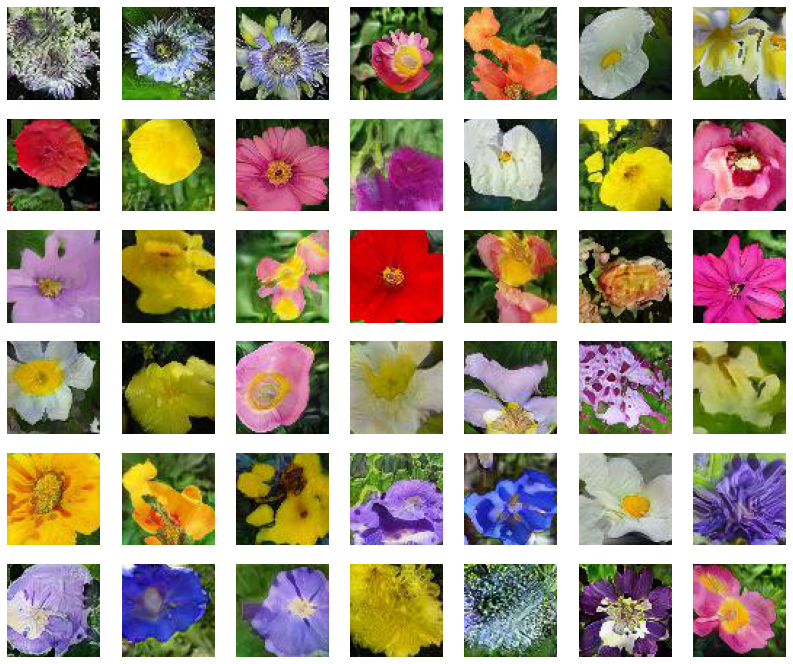

In [46]:
def visualize(idx):
    fig = plt.figure(figsize=(14, 14))
    
    for count, i in enumerate(idx):
        loc = np.where(i==index)[0][0]
        text = ''
        for word in captions[loc]:
            if id2word_dict[word] != '<PAD>':
                text += id2word_dict[word]
                text += ' '
        print(text)
        
        path = '/NA/rabbit2/JBR/Dominic_test/inference_{:04d}.jpg'.format(i)
        fake_iamge = plt.imread(path)
        
        plt.subplot(7, 7, count+1)
        plt.imshow(fake_iamge)
        plt.axis('off')
data = pd.read_pickle('/NA/rabbit2/JBR/dataset/testData.pkl')
captions = data['Captions'].values
index = data['ID'].values
idx = [23, 216, 224, 413, 713, 859, 876, 974, 1177, 1179, 1241, 2169, 2196, 2237, 
       2356, 2611, 2621, 2786, 2951, 2962, 3145, 3255, 3327, 3639, 3654, 3927, 4262, 
       4321, 4517, 5067, 5147, 5955, 6167, 6216, 6410, 6413, 6579, 6584, 6804, 6988, 
       7049, 7160]

visualize(idx)


# Pick 5 descriptions from testing data and generate 5 images with different noise z for each image respectively.

In [188]:
def testing_data_generator(caption, index):
    caption = tf.cast(caption, tf.float32)
    return caption, index

def testing_dataset_generator(batch_size, data_generator):
    data = pd.read_pickle('/NA/rabbit2/JBR/dataset/testData.pkl')
    captions = data['Captions'].values
    caption = []
    for i in range(5):
        for j in range(5):
            caption.append(captions[i])
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    index = []
    for i in range(5):
        for j in range(5):
            index.append(data['ID'].values[i])
    index = np.asarray(index)
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, index))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat().batch(batch_size)
    
    return dataset

In [189]:

testing_dataset = testing_dataset_generator(par['BATCH_SIZE'], testing_data_generator)

In [190]:
data = pd.read_pickle('/NA/rabbit2/JBR/dataset/testData.pkl')
captions = data['Captions'].values

NUM_TEST = len(captions)
EPOCH_TEST = int(NUM_TEST / par['BATCH_SIZE'])

In [191]:
dir = []
def inference(dataset):
    hidden = text_encoder.initialize_hidden_state()
    sample_size = par['BATCH_SIZE']

    step = 0
    start = time.time()
    for captions, idx in dataset:
        if step > 24:
            break
        sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, par['Z_DIM'])).astype(np.float32)
        fake_image = test_step(captions, sample_seed, hidden)
        step += 1
        for i in range(1):
            plt.imsave('/NA/rabbit2/JBR/TEST_inference/' + 'inference_{:04d}_{:d}.jpg'.format(idx[i],step), fake_image[i].numpy())
        dir.append('/NA/rabbit2/JBR/TEST_inference/' + 'inference_{:04d}_{:d}.jpg'.format(idx[i],step))
    print('Time for inference is {:.4f} sec'.format(time.time()-start))

In [192]:
inference(testing_dataset)


Time for inference is 1.9998 sec


In [193]:
new_dir = []
for i in range(len(dir)):
    if "6735" in dir[i]:
        new_dir.append(dir[i])
for i in range(len(dir)):
    if "6740" in dir[i]:
        new_dir.append(dir[i])
for i in range(len(dir)):
    if "6746" in dir[i]:
        new_dir.append(dir[i])
for i in range(len(dir)):
    if "6759" in dir[i]:
        new_dir.append(dir[i])
for i in range(len(dir)):
    if "6762" in dir[i]:
        new_dir.append(dir[i])    

In [194]:
def visualize(idx):
    fig = plt.figure(figsize=(14, 14))
    
    for count, i in enumerate(idx):
        loc = np.where(i==index)[0][0]
        text = ''
        for word in captions[loc]:
            if id2word_dict[word] != '<PAD>':
                text += id2word_dict[word]
                text += ' '
        print(text)
        
        #path = '/NA/rabbit2/JBR/TEST_inference/inference_{:04d}_{:d}.jpg'.format(i,)
        path = new_dir[count] 
        fake_iamge = plt.imread(path)
        
        plt.subplot(5, 5, count+1)
        plt.imshow(fake_iamge)
        plt.axis('off')




this white and purple flower has fragile petals and soft stamens 
this white and purple flower has fragile petals and soft stamens 
this white and purple flower has fragile petals and soft stamens 
this white and purple flower has fragile petals and soft stamens 
this white and purple flower has fragile petals and soft stamens 
this flower has four large wide pink petals with white centers and vein like markings 
this flower has four large wide pink petals with white centers and vein like markings 
this flower has four large wide pink petals with white centers and vein like markings 
this flower has four large wide pink petals with white centers and vein like markings 
this flower has four large wide pink petals with white centers and vein like markings 
a flower with broad white and pink ribbed petals and yellow stamen 
a flower with broad white and pink ribbed petals and yellow stamen 
a flower with broad white and pink ribbed petals and yellow stamen 
a flower with broad white and p

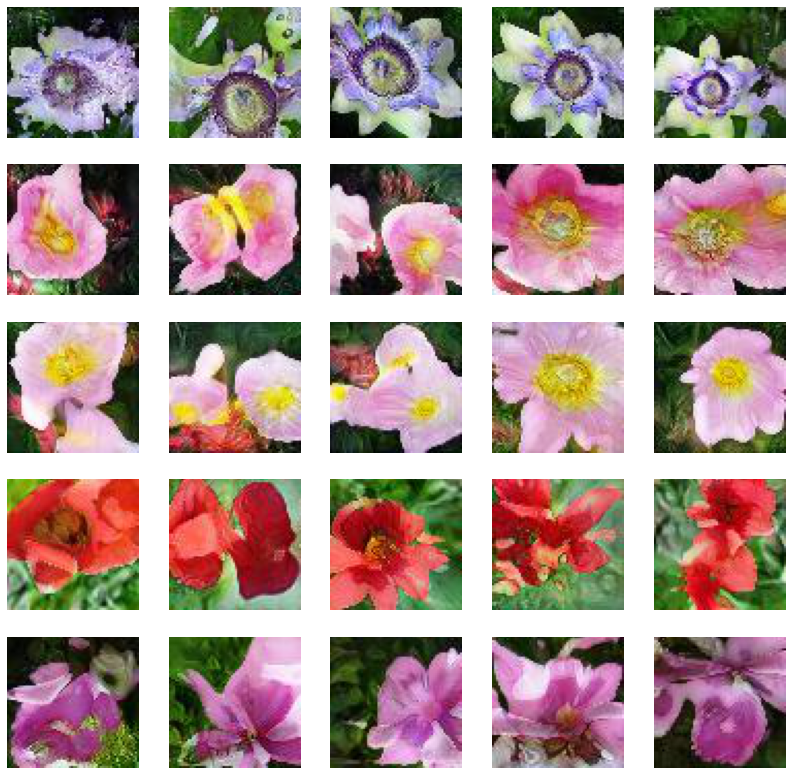

In [195]:
data = pd.read_pickle('/NA/rabbit2/JBR/dataset/testData.pkl')
captions = data['Captions'].values
index = data['ID'].values
idx = [6735,6735,6735,6735,6735,6740,6740,6740,6740,6740,6746,6746,6746,6746,6746,6759,6759,6759,6759,6759,
6762,6762,6762,6762,6762]

visualize(idx)

# Conclusion

   1.本次比賽我們嘗試了許多模型，更換許多種TextEncoder與GAN的架構，最終TextEncoder採用Conditional GAN Model的作法，GAN則是用Deep Fusion GAN，並調整一些參數得出最終的結果。
   
   2.我們曾參考比賽notebook提供的GAN training tips連結，使用裡面建議的方式想讓GAN train得更好，但有時反而效果不佳。例如我們對discriminator使用 SGD；  generator 用 ADAM ，但發現效果不如預期。
    
   3.上次的競賽中，我們並沒有參考太多相關的論文，導致做了很多努力，但一旦方向錯誤，就會陷入比賽後期時間不夠的窘境。
   觀摩上次報告的前三名組作法，每組皆參考了大量的論文再行實作，這樣的作法較為省時且方向不易錯誤，因此本次我們也參考了相關論文，確實比賽狀況有比上次更為理想，故在比賽中閱讀相關論文是必要的作法。
    